In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# plt.style.use('dark_background')
import warnings
warnings.filterwarnings('ignore') 

start = time.perf_counter()

In [2]:
df = pd.read_csv('earl694412-infinite-matchhistory.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705 entries, 0 to 704
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               705 non-null    object 
 1   Player             705 non-null    object 
 2   MatchId            705 non-null    object 
 3   Map                705 non-null    object 
 4   Category           705 non-null    object 
 5   Playlist           705 non-null    object 
 6   Input              705 non-null    object 
 7   Queue              705 non-null    object 
 8   PreCsr             705 non-null    int64  
 9   PostCsr            705 non-null    int64  
 10  Rank               705 non-null    int64  
 11  WasAtStart         705 non-null    int64  
 12  WasAtEnd           705 non-null    int64  
 13  WasInProgressJoin  705 non-null    int64  
 14  Mmr                2 non-null      float64
 15  Outcome            705 non-null    object 
 16  Accuracy           705 non

In [14]:
df['Date'] = pd.to_datetime(df['Date'])
df['LengthMinutes'] = df['LengthSeconds'] / 60
df.rename(columns={'TotalKills': 'Kills'}, inplace=True)
df['DamageRatio'] = df['DamageDone'] / df['DamageTaken']
df['KillsBody'] = df['Kills'] - df['KillsGrenade'] - df['KillsHeadshot'] - df['KillsMelee'] - df['KillsPower']
## Per 10 Mins and Excess
df['Kills/10Min'] = (df['Kills'] / df['LengthMinutes']) * 10
df['Deaths/10Min'] = (df['Deaths'] / df['LengthMinutes']) * 10
df['Assists/10Min'] = (df['Assists'] / df['LengthMinutes']) * 10
df['Dmg/10Min'] = (df['DamageDone'] / df['LengthMinutes']) * 10
df['DmgT/10Min'] = (df['DamageTaken'] / df['LengthMinutes']) * 10
df['ExcessKills'] = df['Kills'] - df['ExpectedKills']
df['ExcessDeaths'] = df['ExpectedDeaths'] - df['Deaths']
df['ExcessKD'] = df['KD'] - round((df['ExpectedKills'] / df['ExpectedDeaths']),2)
## Lifetime
df['LifetimeKD'] = df['Kills'].cumsum() / df['Deaths'].cumsum()
df['LifetimeDmgRatio'] = df['DamageDone'].cumsum() / df['DamageTaken'].cumsum()
df['LifetimeAcc'] = df['ShotsLanded'].cumsum() / df['ShotsFired'].cumsum() * 100
df['LifetimeBodyPct'] = df['KillsBody'].cumsum() / df['Kills'].cumsum() *100
df['LifetimeMeleePct'] = df['KillsMelee'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimeHSPct'] = df['KillsHeadshot'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimeGrenadePct'] = df['KillsGrenade'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimePowerPct'] = df['KillsPower'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimeWinRate'] = (df['Outcome'].cumsum() / 
                          (df['Outcome'].cumsum() + 
                           df['Outcome'].eq(0).cumsum())).fillna(0)

df['Map'] = df['Map'].str.replace(' - Ranked', '')

df = df.drop(['Player', 'MatchId', 'Input', 'Queue', 'Mmr', 'WasAtStart', 'WasAtEnd',
            'WasInProgressJoin', 'AssistsEmp', 'AssistsDriver', 'AssistsCallout', 'VehicleDestroys',
            'VehicleHijacks', 'Perfects', 'PreCsr'],axis=1)
# dfa = df[df['Date']> '2023-01-01']
dfr = df[df['Date'] > '2024-02-04']
dfr = dfr[dfr['Playlist'] == 'Ranked Arena']
dfr['Csr'] = dfr['PostCsr'].replace(0, method='ffill')
dfr = dfr[dfr['Outcome'] != 'Draw']
dfr = dfr[dfr['Outcome'] != 'Left']
dfr['Outcome'] = dfr['Outcome'].map({'Win': 1, 'Loss': 0})
dfr['LifetimeWinRate'] = (dfr['Outcome'].cumsum() / 
                          (dfr['Outcome'].cumsum() + 
                           dfr['Outcome'].eq(0).cumsum())).fillna(0)
dfr = dfr.drop(['Playlist', 'PostCsr'], axis=1).reset_index()
# dfr.loc[:4, 'Csr'] = 808
dfr.to_csv('df.csv')
dfr.info()

TypeError: can only concatenate str (not "int") to str

In [4]:
dfr.tail()

,index,Date,Map,Category,Rank,Outcome,Accuracy,DamageDone,DamageTaken,ShotsFired,...,LifetimeKD,LifetimeDmgRatio,LifetimeAcc,LifetimeBodyPct,LifetimeMeleePct,LifetimeHSPct,LifetimeGrenadePct,LifetimePowerPct,Csr,LifetimeWinRate
12,700,2024-02-07 05:42:18,Forbidden,CTF 3 Captures,5,0,43.61,4230,2542,227,...,1.115260,1.159528,49.661981,28.772269,10.334836,50.268298,7.040137,3.584460,898,0.615385
13,701,2024-02-07 05:51:19,Empyrean,CTF 3 Captures,5,0,47.14,5818,5922,280,...,1.115159,1.159157,49.658387,28.784146,10.326727,50.262453,7.048741,3.577933,890,0.571429
14,702,2024-02-07 06:08:06,Recharge,King of the Hill,5,0,47.66,5871,4220,214,...,1.115605,1.159503,49.656215,28.777671,10.341140,50.251310,7.058069,3.571811,884,0.533333
15,703,2024-02-07 06:19:04,Empyrean,CTF 3 Captures,3,1,46.97,6068,6812,264,...,1.115000,1.158857,49.652610,28.752936,10.356609,50.256246,7.068119,3.566090,894,0.562500
16,704,2024-02-07 06:33:29,Aquarius,CTF 5 Captures,4,1,51.45,5805,3921,241,...,1.116542,1.159301,49.654812,28.735755,10.341889,50.292896,7.072106,3.557354,909,0.588235


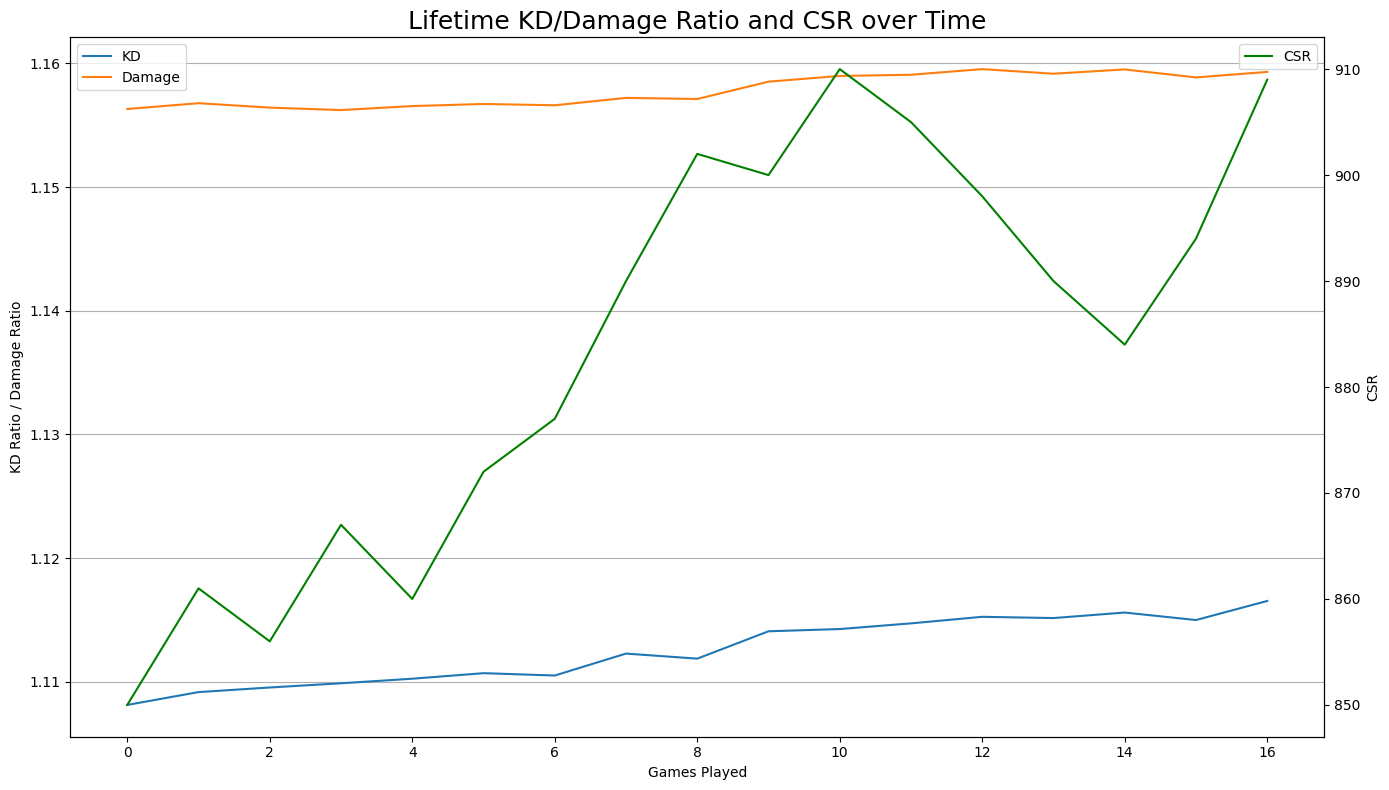

In [5]:
# Smooth the LifetimeWinRate using a 10-game moving average
# dfr['SmoothedAccuracy'] = dfr['Accuracy'].rolling(window=25).mean()

plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeKD'], label='KD' )
ax1.plot(dfr['LifetimeDmgRatio'], label='Damage')
ax2.plot(dfr['Csr'], color='green', label='CSR')
ax1.set_title('Lifetime KD/Damage Ratio and CSR over Time', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('KD Ratio / Damage Ratio')
ax2.set_ylabel('CSR')
# max_y_value = df['LifetimeAcc'].max()
ax1.yaxis.grid(True)
# ax2.set_yticks(np.arange(47, max_y_value, 0.5))
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
# plt.savefig('Plots/DamKDRatiosAcc.png', dpi=300)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


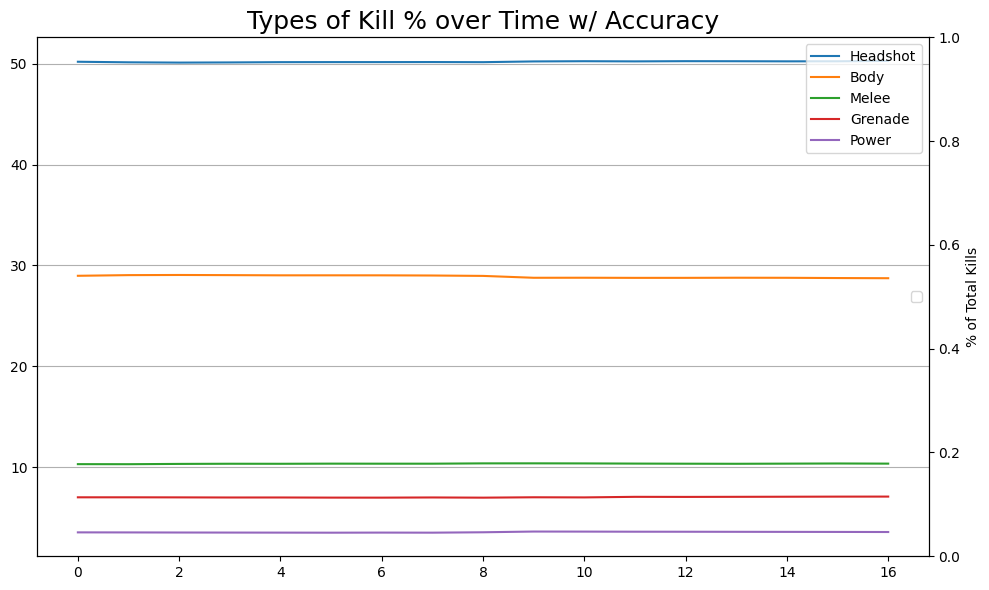

In [6]:
plt.figure(figsize=(10,6))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeHSPct'], label='Headshot')
ax1.plot(dfr['LifetimeBodyPct'], label='Body')
ax1.plot(dfr['LifetimeMeleePct'], label='Melee')
ax1.plot(dfr['LifetimeGrenadePct'], label='Grenade')
ax1.plot(dfr['LifetimePowerPct'], label='Power')
# ax2.plot(dfr['LifetimeAcc'], label='Accuracy', color='black')
plt.title('Types of Kill % over Time w/ Accuracy', fontsize=18)
plt.xlabel('Games Played')
plt.ylabel('% of Total Kills')
ax1.legend(loc='best')
ax2.legend(loc='right')
ax1.grid(True, axis='y')
plt.tight_layout()
# plt.savefig('Plots/DamKDRatios.png', dpi=300)
plt.show()

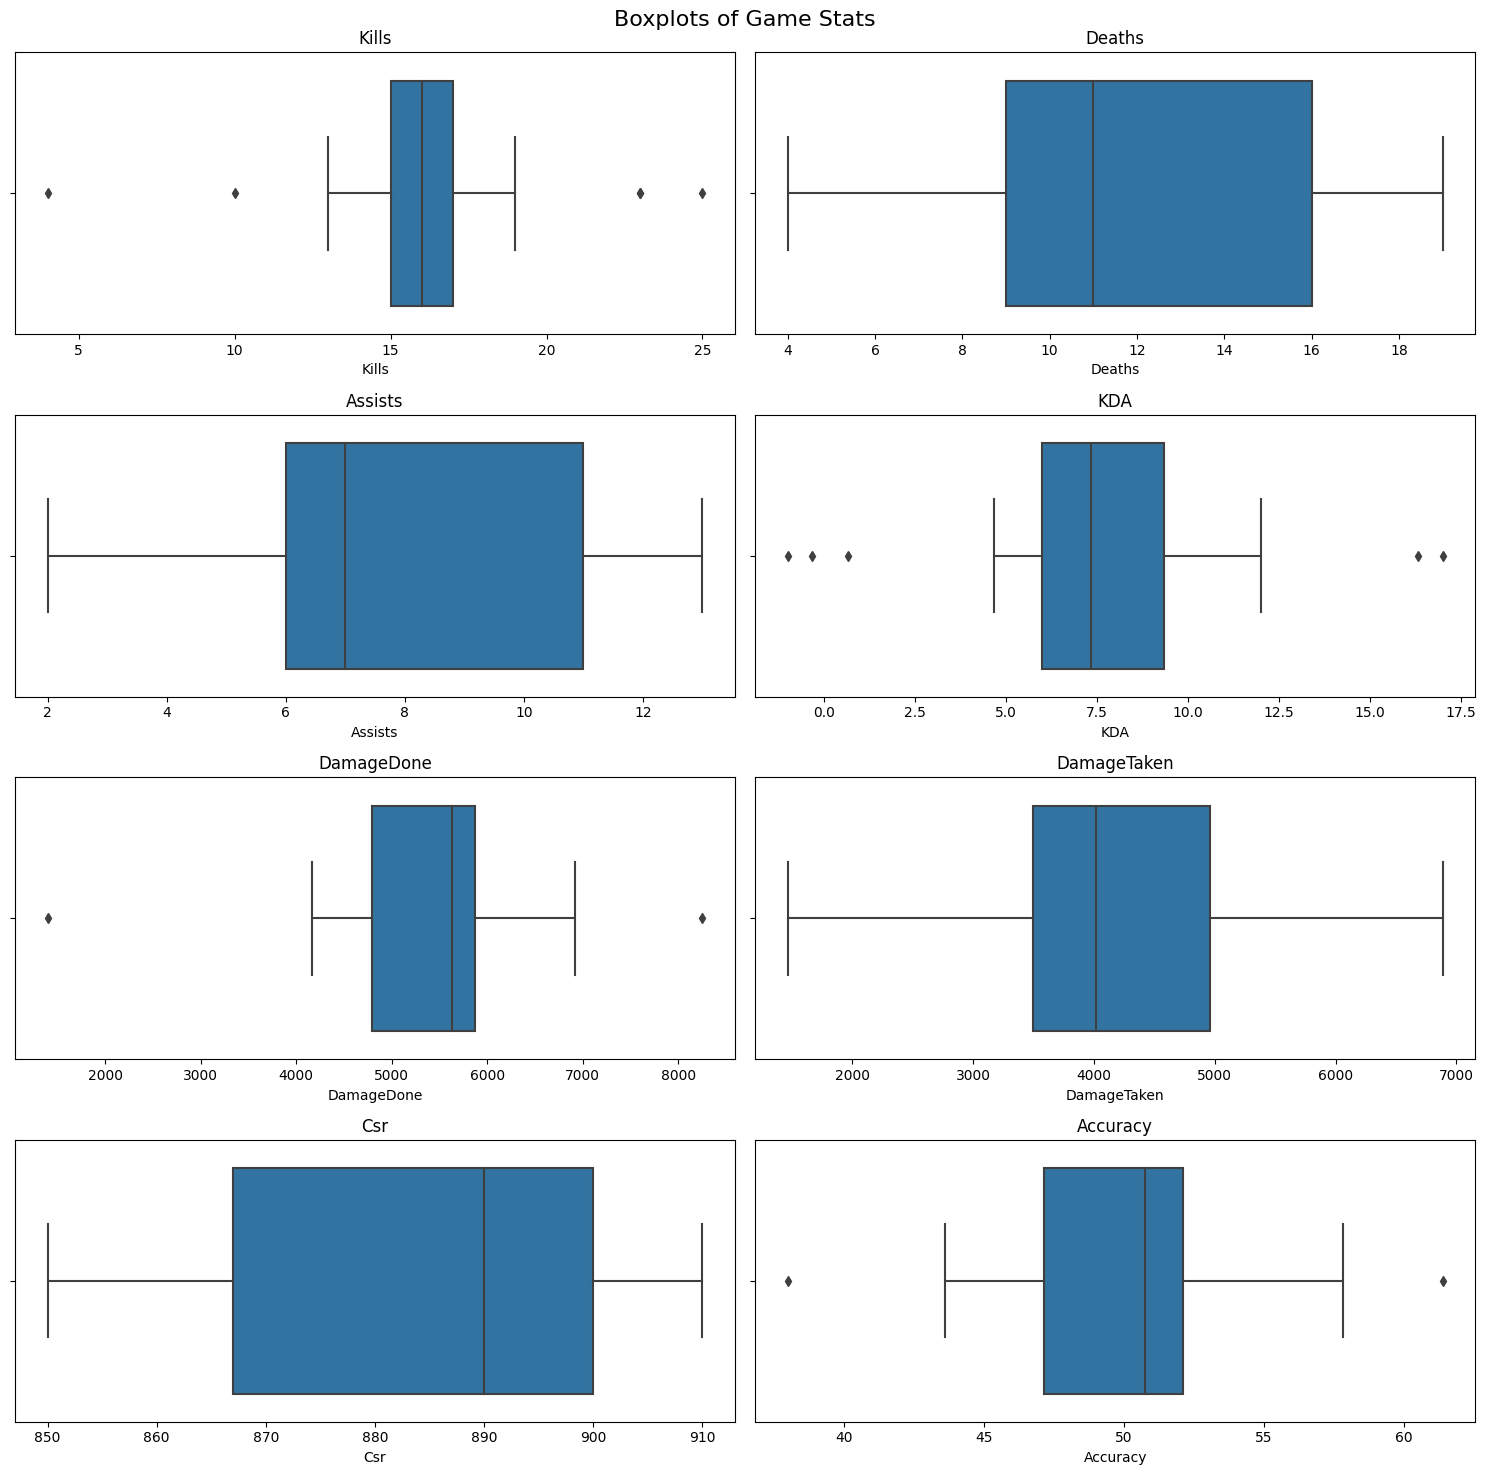

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
columns = ['Kills', 'Deaths', 'Assists', 'KDA', 'DamageDone', 'DamageTaken',
            'Csr', 'Accuracy']

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))

# Flatten the axes for easier iteration
axes = axes.flatten()

# Plot each column in a separate boxplot
for i, column in enumerate(columns):
    sns.boxplot(x=dfr[column], ax=axes[i])
    axes[i].set_title(column)

# Adjust layout
plt.suptitle('Boxplots of Game Stats', fontsize=16)
plt.tight_layout()
plt.savefig('Plots/Boxplots.png', dpi=300)
plt.show()


In [8]:
dfw = dfr.loc[dfr['Outcome'] == 1, 
                ['Kills', 'Deaths', 'Assists', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome', 'ShotsFired', 'ShotsLanded']
                ].sort_values('Kills', ascending=False)

dfl = dfr.loc[dfr['Outcome'] == 0, 
                ['Kills', 'Deaths', 'Assists', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome', 'ShotsFired', 'ShotsLanded']
                ].sort_values('Kills', ascending=False)

print('Overall')
print(f'Overall KD: {round(dfr["Kills"].sum() / dfr["Deaths"].sum(),2)}')
print(f"Average Kills: {round(dfr['Kills'].mean(),2)}")
print(f"Average Deaths: {round(dfr['Deaths'].mean(),2)}")
print(f"Average Assists: {round(dfr['Assists'].mean(),2)}")
print(f"Average Accuracy: {round(dfr['ShotsLanded'].sum() / dfr['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfr['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfr['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfr['DamageDone'].sum() / dfr['DamageTaken'].sum(),2)}")
print(f"Win-Loss: {(dfr['Outcome']==1).sum()}-{(dfr['Outcome']==0).sum()}")
print('----------------------------')
print('Wins')
print(f'Overall KD: {round(dfw["Kills"].sum() / dfw["Deaths"].sum(),2)}')
print(f"Average Kills: {round(dfw['Kills'].mean(),2)}")
print(f"Average Deaths: {round(dfw['Deaths'].mean(),2)}")
print(f"Average Assists: {round(dfw['Assists'].mean(),2)}")
print(f"Average Accuracy: {round(dfw['ShotsLanded'].sum() / dfw['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfw['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfw['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfw['DamageDone'].sum() / dfw['DamageTaken'].sum(),2)}")
print(f"Wins: {(dfw['Outcome']==1).sum()}")
print('----------------------------')
print('Losses')
print(f'Overall KD: {round(dfl["Kills"].sum() / dfl["Deaths"].sum(),2)}')
print(f"Average Kills: {round(dfl['Kills'].mean(),2)}")
print(f"Average Deaths: {round(dfl['Deaths'].mean(),2)}")
print(f"Average Assists: {round(dfl['Assists'].mean(),2)}")
print(f"Average Accuracy: {round(dfl['ShotsLanded'].sum() / dfl['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfl['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfl['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfl['DamageDone'].sum() / dfl['DamageTaken'].sum(),2)}")
print(f"Losses: {(dfl['Outcome']==0).sum()}")

Overall
Overall KD: 1.41
Average Kills: 16.29
Average Deaths: 11.59
Average Assists: 8.06
Average Accuracy: 49.61
Average Damage Done: 5326
Average Damage Taken: 4343
Damage Ratio: 1.23
Win-Loss: 10-7
----------------------------
Wins
Overall KD: 1.54
Average Kills: 15.6
Average Deaths: 10.1
Average Assists: 7.9
Average Accuracy: 49.76
Average Damage Done: 4972
Average Damage Taken: 3896
Damage Ratio: 1.28
Wins: 10
----------------------------
Losses
Overall KD: 1.26
Average Kills: 17.29
Average Deaths: 13.71
Average Assists: 8.29
Average Accuracy: 49.42
Average Damage Done: 5833
Average Damage Taken: 4981
Damage Ratio: 1.17
Losses: 7


In [25]:
dfrcc = dfr.groupby(['Category','Map']).agg({'Category': 'count',
                                             'Kills' : 'sum',
                                             'Deaths' : 'sum',
                                             'Assists' : 'sum',
                                             'ShotsLanded' : 'sum',
                                             'ShotsFired' : 'sum',
                                             'DamageDone': 'sum',
                                             'DamageTaken': 'sum',
                                             'Outcome': 'mean',
                                             'LengthMinutes': 'sum',
                                             })
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['Accuracy'] = (dfrcc['ShotsLanded'] / dfrcc['ShotsFired']) *100
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Kills/10Min'] = dfrcc['Kills'] / dfrcc['LengthMinutes'] * 10
dfrcc['Deaths/10Min'] = dfrcc['Deaths'] / dfrcc['LengthMinutes'] * 10
dfrcc['Assists/10Min'] = dfrcc['Assists'] / dfrcc['LengthMinutes'] * 10
dfrcc['KDA/10Min'] = (dfrcc['Kills/10Min'] + (dfrcc['Assists/10Min'] / 3)) / dfrcc['Deaths/10Min'] 
dfrcc = dfrcc.drop(['ShotsLanded', 'ShotsFired'], axis=1)
# dfrcc = round(dfrcc.sort_values(['Winrate', 'Accuracy'], ascending=False),2)
dfrcc = round(dfrcc.sort_values('Kills/10Min', ascending=False),2)
dfrcc

Count  Kills  Deaths  Assists  DamageDone  \
Category         Map                                                    
CTF 5 Captures   Aquarius       1     23       9        7        5805   
Strongholds      Live Fire      2     36      22        8       10448   
King of the Hill Recharge       3     54      39       29       19061   
Oddball          Recharge       2     33      25       17       10744   
Strongholds      Solitude       2     40      33       21       12284   
                 Recharge       1     14       5        9        4169   
Oddball          Live Fire      1     15      11       10        4450   
CTF 3 Captures   Empyrean       3     48      43       24       17959   
                 Forbidden      2     14      10       12        5629   

                            DamageTaken  Winrate  LengthMinutes  Accuracy  \
Category         Map                                                        
CTF 5 Captures   Aquarius          3921     1.00           8.83     51.45   
Strongholds      Live Fire         8412     0.50          20.32     59.78   
King of the Hill Recharge         14603     0.00          33.92     48.99   
Oddball          Recharge          7757     1.00          21.35     47.38   
Strongholds      Solitude         11670     0.50          27.10     51.98   
                 Recharge          2494     1.00          10.02     37.98   
Oddball          Live Fire         4323     1.00          11.00     51.65   
CTF 3 Captures   Empyrean         16641     0.67          36.65     49.87   
                 Forbidden         4006     0.50          13.02     45.64   

                              KD  DamageRatio  Dmg/Life  ExDmg/Life  \
Category         Map                                                  
CTF 5 Captures   Aquarius   2.56         1.48    645.00      209.33   
Strongholds      Live Fire  1.64         1.24    474.91       92.55   
King of the Hill Recharge   1.38         1.31    488.74      114.31   
Oddball          Recharge   1.32         1.39    429.76      119.48   
Strongholds      Solitude   1.21         1.05    372.24       18.61   
                 Recharge   2.80         1.67    833.80      335.00   
Oddball          Live Fire  1.36         1.03    404.55       11.55   
CTF 3 Captures   Empyrean   1.12         1.08    417.65       30.65   
                 Forbidden  1.40         1.41    562.90      162.30   

                            Kills/10Min  Deaths/10Min  Assists/10Min  \
Category         Map                                                   
CTF 5 Captures   Aquarius         26.04         10.19           7.92   
Strongholds      Live Fire        17.72         10.83           3.94   
King of the Hill Recharge         15.92         11.50           8.55   
Oddball          Recharge         15.46         11.71           7.96   
Strongholds      Solitude         14.76         12.18           7.75   
                 Recharge         13.98          4.99           8.99   
Oddball          Live Fire        13.64         10.00           9.09   
CTF 3 Captures   Empyrean         13.10         11.73           6.55   
                 Forbidden        10.76          7.68           9.22   

                            KDA/10Min  
Category         Map                   
CTF 5 Captures   Aquarius        2.81  
Strongholds      Live Fire       1.76  
King of the Hill Recharge        1.63  
Oddball          Recharge        1.55  
Strongholds      Solitude        1.42  
                 Recharge        3.40  
Oddball          Live Fire       1.67  
CTF 3 Captures   Empyrean        1.30  
                 Forbidden       1.80

In [10]:
dfrcc = dfr.groupby('Category').agg({'Category': 'count',
                                             'Kills' : 'sum',
                                             'Deaths' : 'sum',
                                             'Assists' : 'sum',
                                             'DamageDone': 'sum',
                                             'DamageTaken': 'sum',
                                             'Outcome': 'mean',
                                             })
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Assists/Life'] = dfrcc['Assists'] / dfrcc['Deaths']
dfrcc = round(dfrcc.sort_values('Winrate', ascending=False),2)
dfrcc

,Count,Kills,Deaths,Assists,DamageDone,DamageTaken,Winrate,KD,DamageRatio,Dmg/Life,ExDmg/Life,Assists/Life
Category,,,,,,,,,,,,
CTF 5 Captures,1,23,9,7,5805,3921,1.0,2.56,1.48,645.00,209.33,0.78
Oddball,3,48,36,27,15194,12080,1.0,1.33,1.26,422.06,86.50,0.75
CTF 3 Captures,5,62,53,36,23588,20647,0.6,1.17,1.14,445.06,55.49,0.68
Strongholds,5,90,60,38,26901,22576,0.6,1.50,1.19,448.35,72.08,0.63
King of the Hill,3,54,39,29,19061,14603,0.0,1.38,1.31,488.74,114.31,0.74


In [11]:
dfrcc = dfr.groupby('Map').agg({'Category': 'count',
                                             'Kills' : 'sum',
                                             'Deaths' : 'sum',
                                             'Assists' : 'sum',
                                             'DamageDone': 'sum',
                                             'DamageTaken': 'sum',
                                             'Outcome': 'mean',
                                             })
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Assists/Life'] = dfrcc['Assists'] / dfrcc['Deaths']
dfrcc = round(dfrcc.sort_values('Assists/Life', ascending=False),2)
dfrcc

,Count,Kills,Deaths,Assists,DamageDone,DamageTaken,Winrate,KD,DamageRatio,Dmg/Life,ExDmg/Life,Assists/Life
Map,,,,,,,,,,,,
Forbidden,2,14,10,12,5629,4006,0.50,1.40,1.41,562.90,162.30,1.20
Recharge,6,101,69,55,33974,24854,0.50,1.46,1.37,492.38,132.17,0.80
Aquarius,1,23,9,7,5805,3921,1.00,2.56,1.48,645.00,209.33,0.78
Solitude,2,40,33,21,12284,11670,0.50,1.21,1.05,372.24,18.61,0.64
Empyrean,3,48,43,24,17959,16641,0.67,1.12,1.08,417.65,30.65,0.56
Live Fire,3,51,33,18,14898,12735,0.67,1.55,1.17,451.45,65.55,0.55


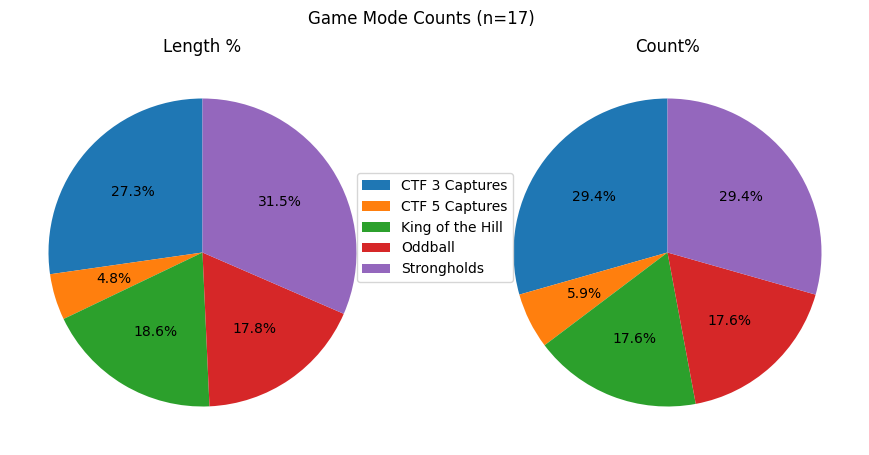

In [23]:
dfrc = dfr.groupby('Category').agg({'LengthMinutes': 'sum', 'Category': 'count'})
dfrc.rename(columns={'Category': 'Count'}, inplace=True)
dfrc['LengthHours'] = round(dfrc['LengthMinutes'] / 60,2)
dfrc['LengthMinutes'] = round(dfrc['LengthMinutes'],2)
dfrc['Length%'] = round(dfrc['LengthMinutes'] / dfrc['LengthMinutes'].sum() * 100,2)
dfrc['Count%'] = round(dfrc['Count'] / dfrc['Count'].sum() * 100,2)
dfrc['TimeMultiple'] = dfrc['Length%'] - dfrc['Count%']
dfrc.sort_values('Length%', ascending=False)

labels = dfrc.index.get_level_values('Category').tolist()
sizes_length = dfrc['Length%'].tolist()
sizes_count = dfrc['Count%'].tolist()
totalcount = dfrc['Count'].sum()


fig, ax = plt.subplots(1, 2, figsize=(11, 5))  # Create a subplot with 1 row and 2 columns
ax[0].pie(sizes_length, labels=None, autopct='%1.1f%%', startangle=90)
ax[1].pie(sizes_count, labels=None, autopct='%1.1f%%', startangle=90)
# Update the title of the plot to include the total game count
fig.suptitle(f'Game Mode Counts (n={totalcount})')




ax[0].set(aspect="equal", title='Length %')
ax[1].set(aspect="equal", title='Count%')
fig.legend(labels, loc="center")

plt.show()

In [12]:
print(f'Runtime: {time.perf_counter() - start}s')

Runtime: 1.9707039160421118s
